In [1]:
import numpy as np
import sys
#np.set_printoptions(precision=5, linewidth=200, suppress=True)
import psi4
from helper_PFCI import PFHamiltonianGenerator
from helper_PFCI import Determinant
from helper_cqed_rhf import cqed_rhf
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)

In [2]:
# options for mgf
mol_str = """
Li
H 1 1.5
symmetry c1
"""

options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    "save_jk" : True
}


psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)


In [3]:
mol_str = """
Li
H 1 1.5
symmetry c1
"""

options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

cavity_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0]),
    'ci_level' : 'fci',
    'full_diagonalization' : True,
    'no_cavity' : True
}

mol = psi4.geometry(mol_str)

psi4.set_options(options_dict)

test_pf = PFHamiltonianGenerator(
    mol_str,
    options_dict,
    cavity_dict
)




Start SCF iterations:

Canonical RHF One-electron energy = -12.5626302721254959
CQED-RHF One-electron energy      = -12.5626302721254959
Nuclear repulsion energy          = 1.0583544213400000
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8633576215383263   dE = -7.86336E+00   dRMS = 3.54673E-13
SCF Iteration   2: Energy = -7.8633576215383370   dE = -1.06581E-14   dRMS = 7.99578E-14
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.86335762 hartree
Psi4  SCF energy: -7.86335762 hartree
 Completed QED-RHF in 0.35506105422973633 seconds
 Completed 1HSO Build in 0.0002570152282714844 seconds
 Completed ERI Build in 0.0013339519500732422 seconds 
 Completed 2D build in 0.00013709068298339844 seconds
 Completed 1G build in 1.811981201171875e-05 seconds
 Completed the Dipole Matrix Build in 4.482269287109375e-05 seconds
 Completed determinant list in 0.00049591064453125 seconds 
 Completed constant offset matrix in 0.00020503997802734

In [4]:
def reduce_ci_space(instance):
    """
    function to map QED-CI space to electronic subspace for when 
    there is no cavity effect
    """
    # make the CI matrix in the electronic subspace only
    _H_CI_NO_CAV = instance.ApDmatrix + instance.Enuc_so + instance.dc_so
    
    # diagonize only the electronic subspace CI matrix
    instance.CIeigs, instance.CIvecs = np.linalg.eigh(_H_CI_NO_CAV)
    
    # get the number of determinants
    _numDets = len(instance.CIeigs)
    
    # reduce the dipole arrays to the electronic subspace
    instance.MU_X = np.copy(instance.MU_X[:_numDets, :_numDets])
    instance.MU_Y = np.copy(instance.MU_Y[:_numDets, :_numDets])
    instance.MU_Z = np.copy(instance.MU_Z[:_numDets, :_numDets])


This block will identify $N_{el}$ of the excited-states with optically-allowed transitions from the ground-state.

In [5]:
def sort_dipole_allowed_states(instance, N_el):
    """
    A function to capture the indices of states with a dipole-allowed
    singlet transition from the ground-state
    """
    
    # we want to find the first N_el states that are coupled to the ground state through a dipole transition
    _singlet_states = [0]
    _num_kets = 0
    _ket_idx = 1
    _sing_idx = 1
    zero_vec = np.array([0., 0., 0.])
    while _num_kets < N_el - 1:
        _tmp_mu = instance.compute_dipole_moment(0, _ket_idx)
        if np.allclose(zero_vec, _tmp_mu):
            _ket_idx += 1
        else:
            _singlet_states.append(_ket_idx)
            _ket_idx += 1
            _num_kets += 1
            _sing_idx += 1
            
    return _singlet_states


def compute_dipole_moments(instance, states):
    """
    Given an array of states, compute all the dipole moments between those states
    """
    _Ns = len(states)
    _singlet_dipole_moments = np.zeros((_Ns, _Ns, 3))
    
    for i in range(_Ns):
        a = states[i]
        for j in range(_Ns):
            b = states[j]
            _singlet_dipole_moments[i, j, :] = instance.compute_dipole_moment(a, b) + instance.mu_nuc * (a==b)
    
    return _singlet_dipole_moments




In [6]:
N_el = 20
reduce_ci_space(test_pf)
singlet_states = sort_dipole_allowed_states(test_pf, N_el)
print(singlet_states)


[0, 2, 5, 6, 8, 14, 15, 16, 17, 21, 22, 23, 24, 26, 29, 30, 38, 40, 41, 49]


In [7]:
print(compute_dipole_moments(test_pf, singlet_states))

[[[ 1.39268461e-15  1.16301812e-15 -1.82288146e+00]
  [ 7.50236804e-15  7.43351177e-15  6.69131627e-01]
  [ 1.24542920e+00  6.60115855e-01 -4.57184430e-15]
  [ 6.60115855e-01 -1.24542920e+00  6.20687401e-16]
  [ 2.57272550e-15  4.05305125e-16  3.76232818e-01]
  [ 8.56814648e-15  1.10675877e-14  6.28943285e-01]
  [-6.09031877e-02 -9.76448927e-02  6.82675065e-14]
  [-9.76448927e-02  6.09031877e-02  1.64683767e-15]
  [ 1.32675591e-15 -2.87437460e-16  8.15924833e-02]
  [ 7.21392967e-03 -7.57645375e-02 -1.49553095e-15]
  [-7.57645375e-02 -7.21392967e-03 -1.94695467e-15]
  [ 1.86108357e-16 -4.27801400e-16  4.40126361e-02]
  [-4.47024244e-16  1.29898523e-16 -7.92363071e-02]
  [ 9.02119554e-16 -2.40455709e-15  2.15979931e-01]
  [ 1.60470820e-01 -2.54179863e-01 -1.61559480e-15]
  [-2.54179863e-01 -1.60470820e-01 -1.06877854e-16]
  [ 2.50467830e-16 -3.00124343e-16 -4.58432478e-02]
  [ 9.69499501e-03 -2.21731073e-02 -2.46309711e-16]
  [-2.21731073e-02 -9.69499501e-03  5.34259049e-16]
  [ 1.886376

In [8]:
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""

mol_str = """
Li
H 1 1.5
symmetry c1
"""

N_R = 50
N_el = 20
r_array = np.linspace(1.4, 2.2, N_R)

E_array = np.zeros((N_R, N_el))
Mu_array = np.zeros((N_R, N_el, N_el, 3))
psi4.set_options(options_dict)

r_idx = 0
for r in r_array:
    mol_str = mol_tmpl.replace("**R**", str(r))
    print(mol_str)
    mol = psi4.geometry(mol_str)
    #psi4.set_options({'restricted_docc': [3],'active': [4],'num_roots':2})
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy = psi4.energy('fci',ref_wfn=wfn)
    
    LiH = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    assert np.isclose(fci_energy, LiH.CIeigs[0])
    reduce_ci_space(LiH)
    singlet_states = sort_dipole_allowed_states(LiH,  N_el)
    E_array[r_idx, :] = LiH.CIeigs[singlet_states]
    Mu_array[r_idx, :, :, :] = compute_dipole_moments(LiH, singlet_states)
    r_idx += 1
    
    
    #CASCI_E_array.append(H2_PF.CIeigs[0])
    #FCI_E_array.append(fci_energy)
    #print(r, H2_PF.CIeigs[0])



Li
H 1 1.4
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.6946346236295895
CQED-RHF One-electron energy      = -12.6946346236295895
Nuclear repulsion energy          = 1.1339511657214287
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8605386610570385   dE = -7.86054E+00   dRMS = 1.78770E-13
SCF Iteration   2: Energy = -7.8605386610570473   dE = -8.88178E-15   dRMS = 3.97284E-14
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.86053866 hartree
Psi4  SCF energy: -7.86053866 hartree
 Completed QED-RHF in 0.08633804321289062 seconds
 Completed 1HSO Build in 2.8133392333984375e-05 seconds
 Completed ERI Build in 0.0011436939239501953 seconds 
 Completed 2D build in 7.510185241699219e-05 seconds
 Completed 1G build in 1.5020370483398438e-05 seconds
 Completed the Dipole Matrix Build in 3.910064697265625e-05 seconds
 Completed determinant list in 0.0004401206970214844 seconds 
 Completed constant offset m

 Completed Hamiltonian build in 0.343768835067749 seconds

Li
H 1 1.530612244897959
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.5241587898228026
CQED-RHF One-electron energy      = -12.5241587898228026
Nuclear repulsion energy          = 1.0371873329132002
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8633023030157272   dE = -7.86330E+00   dRMS = 2.68148E-13
SCF Iteration   2: Energy = -7.8633023030157201   dE =  7.10543E-15   dRMS = 5.97575E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86330230 hartree
Psi4  SCF energy: -7.86330230 hartree
 Completed QED-RHF in 0.08923912048339844 seconds
 Completed 1HSO Build in 2.9087066650390625e-05 seconds
 Completed ERI Build in 0.0011529922485351562 seconds 
 Completed 2D build in 9.584426879882812e-05 seconds
 Completed 1G build in 1.52587890625e-05 seconds
 Completed the Dipole Matrix Build in 4.076957702636719e-05 seconds
 Completed determinant 

 Completed Hamiltonian build in 0.3413429260253906 seconds

Li
H 1 1.6612244897959183
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.3692821733550495
CQED-RHF One-electron energy      = -12.3692821733550495
Nuclear repulsion energy          = 0.9556394345023342
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8593008679750440   dE = -7.85930E+00   dRMS = 2.89643E-15
SCF Iteration   2: Energy = -7.8593008679750422   dE =  1.77636E-15   dRMS = 7.61755E-16
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.85930087 hartree
Psi4  SCF energy: -7.85930087 hartree
 Completed QED-RHF in 0.09452390670776367 seconds
 Completed 1HSO Build in 2.9802322387695312e-05 seconds
 Completed ERI Build in 0.001194000244140625 seconds 
 Completed 2D build in 8.0108642578125e-05 seconds
 Completed 1G build in 1.5020370483398438e-05 seconds
 Completed the Dipole Matrix Build in 4.1961669921875e-05 seconds
 Completed determinan

 Completed Hamiltonian build in 0.3405590057373047 seconds

Li
H 1 1.7918367346938777
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.2279483802846354
CQED-RHF One-electron energy      = -12.2279483802846354
Nuclear repulsion energy          = 0.8859800679782459
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8506745764107793   dE = -7.85067E+00   dRMS = 5.05083E-15
SCF Iteration   2: Energy = -7.8506745764107757   dE =  3.55271E-15   dRMS = 1.33471E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.85067458 hartree
Psi4  SCF energy: -7.85067458 hartree
 Completed QED-RHF in 0.0984489917755127 seconds
 Completed 1HSO Build in 3.790855407714844e-05 seconds
 Completed ERI Build in 0.001216888427734375 seconds 
 Completed 2D build in 7.915496826171875e-05 seconds
 Completed 1G build in 1.5735626220703125e-05 seconds
 Completed the Dipole Matrix Build in 4.220008850097656e-05 seconds
 Completed determin

 Completed Hamiltonian build in 0.34381699562072754 seconds

Li
H 1 1.9224489795918367
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.0985141762878570
CQED-RHF One-electron energy      = -12.0985141762878570
Nuclear repulsion energy          = 0.8257860930837581
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8389192441347433   dE = -7.83892E+00   dRMS = 5.36166E-15
SCF Iteration   2: Energy = -7.8389192441347486   dE = -5.32907E-15   dRMS = 1.35759E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.83891924 hartree
Psi4  SCF energy: -7.83891924 hartree
 Completed QED-RHF in 0.09371066093444824 seconds
 Completed 1HSO Build in 3.1948089599609375e-05 seconds
 Completed ERI Build in 0.00119781494140625 seconds 
 Completed 2D build in 9.226799011230469e-05 seconds
 Completed 1G build in 1.5735626220703125e-05 seconds
 Completed the Dipole Matrix Build in 4.315376281738281e-05 seconds
 Completed determ

 Completed Hamiltonian build in 0.3470458984375 seconds

Li
H 1 2.053061224489796
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -11.9796907659129843
CQED-RHF One-electron energy      = -11.9796907659129843
Nuclear repulsion energy          = 0.7732509937225647
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8250927429137160   dE = -7.82509E+00   dRMS = 3.20782E-15
SCF Iteration   2: Energy = -7.8250927429137231   dE = -7.10543E-15   dRMS = 9.34040E-16
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.82509274 hartree
Psi4  SCF energy: -7.82509274 hartree
 Completed QED-RHF in 0.08974790573120117 seconds
 Completed 1HSO Build in 2.7894973754882812e-05 seconds
 Completed ERI Build in 0.0012881755828857422 seconds 
 Completed 2D build in 0.00011396408081054688 seconds
 Completed 1G build in 1.4066696166992188e-05 seconds
 Completed the Dipole Matrix Build in 4.100799560546875e-05 seconds
 Completed determin

 Completed Hamiltonian build in 0.3449819087982178 seconds

Li
H 1 2.183673469387755
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -11.8704521229909687
CQED-RHF One-electron energy      = -11.8704521229909687
Nuclear repulsion energy          = 0.7270004669952337
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8099506130038581   dE = -7.80995E+00   dRMS = 6.41765E-15
SCF Iteration   2: Energy = -7.8099506130038581   dE =  0.00000E+00   dRMS = 1.84787E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.80995061 hartree
Psi4  SCF energy: -7.80995061 hartree
 Completed QED-RHF in 0.0941469669342041 seconds
 Completed 1HSO Build in 4.100799560546875e-05 seconds
 Completed ERI Build in 0.001216888427734375 seconds 
 Completed 2D build in 9.918212890625e-05 seconds
 Completed 1G build in 1.7881393432617188e-05 seconds
 Completed the Dipole Matrix Build in 4.291534423828125e-05 seconds
 Completed determinant 

In [9]:
from matplotlib import pyplot as plt


In [ ]:
print(r_array)
print(E_array[:,1]-E_array[:,0])

plt.plot(r_array, E_array[:,0]+0.120000)
plt.plot(r_array, E_array[:,1])
plt.plot(r_array, E_array[:,2])

plt.show()

\begin{equation}
\hat{H}_{\alpha n, \beta m} = \left( E_{\alpha}(R) + n \omega \right) \delta_{\alpha \beta} \delta_{nm} + \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{\alpha \beta}(R) \left(\sqrt{n} \delta_{n,m-1} + \sqrt{n+1} \delta_{n,m+1} \right)  \\
+\frac{1}{2} \sum_{\gamma = 1}^N \lambda \cdot \mu_{\alpha, \gamma}(R) \lambda \cdot \mu_{\gamma, \beta} \delta_{nm}
\end{equation}


In [10]:
def build_pf_hamiltonian(n_el, n_ph, E_R, omega, lamvec, mu):
    """
    Given an array of n_el E_R values and an n_ph states with fundamental energy omega
    build the PF Hamiltonian
    
    n_el : int
        the number of electronic states (n_el = 1 means only ground-state)
    
    n_ph : int
        the number of photon occupation states (n_ph = 1 means only the |0> state)
    
    E_R : np.array of floats
        the electronic energies
        
    omega : float
        the energy of the photonic mode
        
    lamvec : np.array of floats
        the lambda vector
        
    mu : (n_el x n_el x 3) np.array of floats 
        mu[i, j, k] is the kth cartesian component of the dipole moment expectation value between 
        state i and state j
    
    """
    H_PF = np.zeros((n_el * n_ph, n_el * n_ph))
    
    # take care of the diagonals first
    # bare electronic and photonic energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            H_PF[na,na] = E_R[a] + n * omega
        
    # diagonal dipole self energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            for g in range(n_el):
                H_PF[na,na] += 0.5 * np.dot(lamvec, mu[a,g,:]) * np.dot(lamvec, mu[g,a,:])
            
    # off-diagonal dipole self energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            for b in range(n_el):
                nb = n * n_el + b
                for g in range(n_el):
                    if a != b:
                        H_PF[na, nb] += 0.5 * np.dot(lamvec, mu[a,g,:]) * np.dot(lamvec, mu[g, b, :])
                
    # off-diagonal bilinear coupling
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            
            for m in range(n_ph):
                for b in range(n_el):
                    mb = m * n_el + b
                    
                    if n == (m-1) and a != b:
                        #print(n, a, na, m, b, mb)
                        H_PF[na,mb] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m) 
                        H_PF[mb, na] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m) 
                        
                    elif n == (m+1) and a != b:
                        #print(n, a, na, m, b, mb)
                        H_PF[na, mb] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m+1) 
                        H_PF[mb, na] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m+1)
                        
    
    return H_PF
                
            
    
        
    
    

\begin{equation}
\hat{H}_{\alpha n, \beta m} = \left( E_{\alpha}(R) + n \omega \right) \delta_{\alpha \beta} \delta_{nm} + \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{\alpha \beta}(R) \left(\sqrt{n} \delta_{n,m-1} + \sqrt{n+1} \delta_{n,m+1} \right)  \\
+\frac{1}{2} \sum_{\gamma = 1}^N \lambda \cdot \mu_{\alpha, \gamma}(R) \lambda \cdot \mu_{\gamma, \beta} \delta_{nm}
\end{equation}


In [12]:
np.set_printoptions(precision=6, linewidth=200, suppress=True)
omega_cav = 0.120000
lambda_vector = np.array([0, 0.0, 0.05])

N_ph = 2
# Just manually computing some elements!
#print("E")
#print(E_array[0,:2], E_array[0,:2]+0.12, E_array[0,:2]+2*0.12)

#g_12 = np.sqrt(omega_cav / 2) * np.dot(lambda_vector, Mu_array[0, 0, 1, :]) * np.sqrt(2)
#D_01 = 0.5 * np.dot(lambda_vector, Mu_array[0, 0, 0, :]) * np.dot(lambda_vector, Mu_array[0, 1, 0, :]) 
#D_01 += 0.5 * np.dot(lambda_vector, Mu_array[0, 0, 1, :]) * np.dot(lambda_vector, Mu_array[0, 1, 1, :])
#print("g12 * 1")
#print(g_12)
#print("D01")
#print(D_01)
#+E_array[0,1])

_HPF = build_pf_hamiltonian(N_el, N_ph, E_array[0,:], omega_cav, lambda_vector, Mu_array[0, :, :, :])
print("H")
print(_HPF)

H
[[-7.873256 -0.000726  0.        0.       -0.000694 -0.002798 -0.       -0.       -0.001146  0.       -0.       -0.000933  0.000872 -0.000466  0.       -0.       -0.000169  0.       -0.
  -0.        0.       -0.007386  0.        0.       -0.003736 -0.006673 -0.       -0.       -0.001073  0.       -0.       -0.000506  0.000786 -0.002692  0.       -0.       -0.000463  0.
  -0.       -0.      ]
 [-0.000726 -7.730758 -0.       -0.        0.000953  0.000003  0.       -0.        0.000664 -0.        0.       -0.001807 -0.001878  0.000452 -0.       -0.       -0.00014   0.       -0.
   0.       -0.007386  0.        0.        0.        0.00058   0.010668  0.        0.        0.002001  0.       -0.        0.006252 -0.002026 -0.00145  -0.        0.        0.000333 -0.
   0.       -0.      ]
 [ 0.       -0.       -7.682085 -0.000004 -0.       -0.       -0.000434  0.000717  0.       -0.000927 -0.000333 -0.        0.        0.        0.000104 -0.000386 -0.       -0.000234  0.000145
  -0.000064  0. 

In [34]:
N_el = 6
N_ph = 4

PF_EIG = np.zeros((N_R, N_el * N_ph))

In [35]:

for i in range(N_R):
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[i,:], omega_cav, lambda_vector, Mu_array[i, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)
    PF_EIG[i,:] = pf_e
    print(r_array[i], pf_e[0], pf_e[1],  pf_e[2], pf_e[2])

1.4 -7.873627152887874 -7.756190312201736 -7.729166043035704 -7.729166043035704
1.4163265306122448 -7.874562248508866 -7.757262523661146 -7.730567115241893 -7.730567115241893
1.4326530612244897 -7.875361103078303 -7.758207784678515 -7.7318593956779775 -7.7318593956779775
1.4489795918367345 -7.876030537778752 -7.759033669179541 -7.733047066639927 -7.733047066639927
1.4653061224489796 -7.876577048973588 -7.759747490834279 -7.734133971775618 -7.734133971775618
1.4816326530612245 -7.877006827556565 -7.760356325193096 -7.735123633056283 -7.735123633056283
1.4979591836734694 -7.8773257768975355 -7.760867029575956 -7.736019266799177 -7.736019266799177
1.5142857142857142 -7.877539529489917 -7.761286260460852 -7.7368237992607805 -7.7368237992607805
1.530612244897959 -7.87765346240097 -7.7616204880406885 -7.737539882387239 -7.737539882387239
1.546938775510204 -7.877672711620623 -7.76187600754317 -7.738169910367052 -7.738169910367052
1.5632653061224488 -7.87760218539925 -7.762058946848616 -7.7387

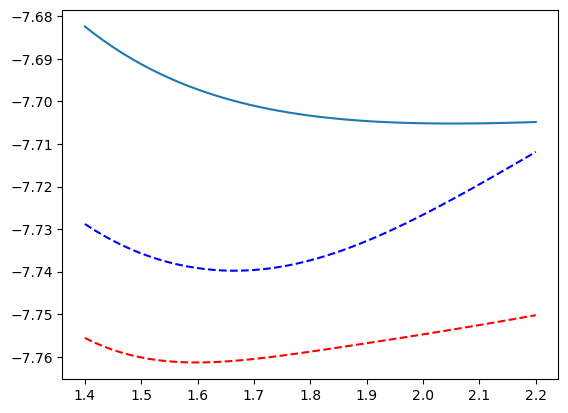

In [15]:
#plt.plot(r_array, PF_EIG[:,0])
#plt.plot(r_array, E_array[:,1])
plt.plot(r_array, PF_EIG[:,1], 'r--')
plt.plot(r_array, PF_EIG[:,2], 'b--')
#plt.plot(r_array, E_array[:,0]+omega_cav)
#plt.plot(r_array, E_array[:,2])
plt.plot(r_array, E_array[:,3])
#plt.plot(r_array, PF_EIG[:,3])
#plt.plot(r_array, PF_EIG[:,4])
#plt.plot(r_array, PF_EIG[:,5])





In [ ]:
pf_e, pf_c = np.linalg.eigh(_HPF)
print(pf_e)

In [ ]:
print(pf_e[2]-pf_e[0])
#print(pf_e[3])
print(omega_cav)
#print(pf_e[1]-pf_e[0])
#print(pf_e[2]-pf_e[1])

In [ ]:
expected_mghp_g_e = -199.86358254419457
expected_mghp_lp_e = -199.69776087489558
expected_mghp_up_e = -199.68066502792058

print(expected_mghp_lp_e-expected_mghp_g_e)
print(expected_mghp_up_e-expected_mghp_lp_e)